In [45]:
import pandas as pd 
df = pd.read_csv("../prep_data/hotelid0_daily_merged.csv")

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46084 entries, 0 to 46083
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           46084 non-null  int64  
 1   datum_dolaska        46084 non-null  object 
 2   datum_odjave         46084 non-null  object 
 3   kanal_prodaje_id     46084 non-null  int64  
 4   tip_sobe_id          46084 non-null  int64  
 5   cijena_nocenja       46084 non-null  float64
 6   rezervacija_id       46084 non-null  int64  
 7   gost_id              46084 non-null  int64  
 8   zemlja_gosta_mapped  46084 non-null  int64  
 9   total_occupancy      46084 non-null  float64
dtypes: float64(2), int64(6), object(2)
memory usage: 3.5+ MB


In [47]:
df = df.drop(columns=["Unnamed: 0"], axis=1)

Kako bi random forest algoritam mogao da razume vremenske serije moramo iz datuma izvuci odredjene podatke, kao sto je to u narednom cell-u

In [48]:
df['datum_dolaska'] = pd.to_datetime(df['datum_dolaska'])
df['datum_odjave'] = pd.to_datetime(df['datum_odjave'])

df['day_of_week'] = df['datum_dolaska'].dt.day_of_week
df['month'] = df['datum_dolaska'].dt.month
df['year'] = df['datum_dolaska'].dt.year
df['week_of_year'] = df['datum_dolaska'].dt.isocalendar().week
df['week_of_month'] = df['datum_dolaska'].dt.day // 7 + 1

In [49]:
df.tail()

,datum_dolaska,datum_odjave,kanal_prodaje_id,tip_sobe_id,cijena_nocenja,rezervacija_id,gost_id,zemlja_gosta_mapped,total_occupancy,day_of_week,month,year,week_of_year,week_of_month
46079,2017-08-30,2017-09-06,2,1,83.444595,1432428,1063376,13,359.0,2,8,2017,35,5
46080,2017-08-31,2017-09-07,2,3,201.924145,1432429,1088912,5,358.0,3,8,2017,35,5
46081,2017-08-31,2017-09-07,2,2,148.455148,1432430,1101990,12,358.0,3,8,2017,35,5
46082,2017-08-31,2017-09-07,2,1,101.498939,1432431,1053323,3,358.0,3,8,2017,35,5
46083,2017-10-29,2017-11-07,2,1,193.709372,1432432,1013647,13,360.0,6,10,2017,43,5


In [50]:
from sklearn.model_selection import train_test_split
X = df.drop(columns=["total_occupancy", "datum_dolaska", "datum_odjave", "rezervacija_id"], axis=1)
y = df["total_occupancy"]
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8, random_state=27)

In [51]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

tscv = TimeSeriesSplit(n_splits=5)

model = RandomForestRegressor(random_state=27, n_jobs=-1, min_samples_split =3, max_samples=800, n_estimators=73)

rmse_scores = []
r2_scores = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)
    rmse_scores.append(rmse)

print("Mean RMSE:", np.mean(rmse_scores))
print("Mean R2:", np.mean(r2_scores))

Mean RMSE: 73.10480225140398
Mean R2: 0.7627583221489023


### XGBoost algoritam ###

In [52]:
from sklearn.model_selection import train_test_split

# Assume X is your feature matrix and y is your target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model on the training data
xgb_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_xgb = xgb_model.predict(X_test)

# Calculate metrics on the test data
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

# Print metrics
print(f'Mean Absolute Error (XGB): {mae_xgb}')
print(f'Mean Squared Error (XGB): {mse_xgb}')
print(f'Root Mean Squared Error (XGB): {rmse_xgb}')
print(f'R2 (XGB): {r2_xgb}')

Mean Absolute Error (XGB): 6.529002778375176
Mean Squared Error (XGB): 83.16291108491528
Root Mean Squared Error (XGB): 9.11937010351676
R2 (XGB): 0.9984326506001197


### Optimizacija hiperparametara ###

In [53]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [2, 3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.4, 0.6, 0.8, 1.0]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=xgb.XGBRegressor(objective ='reg:squarederror'),
                           param_grid=param_grid,
                           cv=3,
                           scoring='neg_mean_squared_error',
                           verbose=2,
                           n_jobs=-1)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 300, 'subsample': 1.0}
Best score: -5.573835970150281


In [54]:
# Get the best parameters
best_params = grid_search.best_params_

# Create a new XGBoost model with the best parameters
best_xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', 
                                  n_estimators=best_params['n_estimators'], 
                                  max_depth=best_params['max_depth'], 
                                  learning_rate=best_params['learning_rate'], 
                                  subsample=best_params['subsample'], 
                                  colsample_bytree=best_params['colsample_bytree'])

# Train the model on the training data
best_xgb_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_best_xgb = best_xgb_model.predict(X_test)

# Calculate metrics on the test data
mae_best_xgb = mean_absolute_error(y_test, y_pred_best_xgb)
mse_best_xgb = mean_squared_error(y_test, y_pred_best_xgb)
rmse_best_xgb = np.sqrt(mse_best_xgb)
r2_best_xgb = r2_score(y_test, y_pred_best_xgb)

# Print metrics
print(f'Mean Absolute Error (Best XGB): {mae_best_xgb}')
print(f'Mean Squared Error (Best XGB): {mse_best_xgb}')
print(f'Root Mean Squared Error (Best XGB): {rmse_best_xgb}')
print(f'R2 (Best XGB): {r2_best_xgb}')




Mean Absolute Error (Best XGB): 0.7367164971474855
Mean Squared Error (Best XGB): 1.9737937742586131
Root Mean Squared Error (Best XGB): 1.404917710849505
R2 (Best XGB): 0.9999628004305379


kanal_prodaje_id: 4.322041604609694e-06
tip_sobe_id: 5.316095666785259e-06
cijena_nocenja: 9.739016604726203e-06
gost_id: 4.61956869912683e-06
zemlja_gosta_mapped: 1.1041129255318083e-05
day_of_week: 0.013638485223054886
month: 0.4259885251522064
year: 0.4625515043735504
week_of_year: 0.08977869153022766
week_of_month: 0.0080077163875103


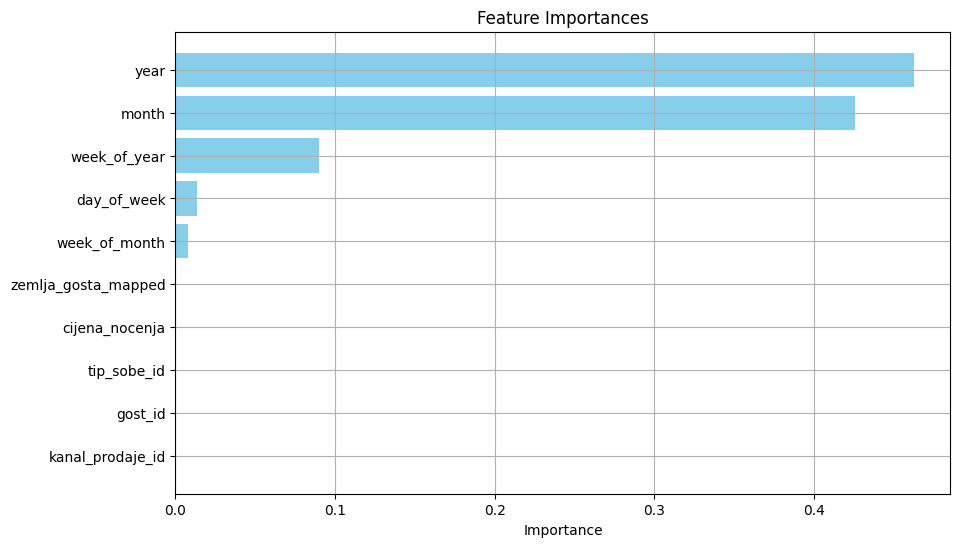

In [59]:
import matplotlib.pyplot as plt


# Get feature importances
feature_importances = best_xgb_model.feature_importances_

# Create a dictionary of feature importances
feature_importance_dict = dict(zip(X.columns, feature_importances))

# Print the feature importances
for feature, importance in feature_importance_dict.items():
    print(f'{feature}: {importance}')
    

# Sort the dictionary by values in descending order
feature_importance_dict_sorted = dict(sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True))

# Create lists of feature names and importances
features = list(feature_importance_dict_sorted.keys())
importances = list(feature_importance_dict_sorted.values())

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert the y-axis so the feature with the highest importance is at the top
plt.grid()
plt.show()